In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing as pp
from pyod.models.iforest import IForest

import os
import warnings

plt.style.use('bmh')
warnings.filterwarnings('ignore')

RS = 8 #random_state

# IO utils


In [2]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

    Parameters:
    ---ы
        path_palm_data  (str): path to csv data file
        n_omg_channels  (int): Number of OMG channels
        n_acc_channels  (int): Number of Accelerometer channels,      default = 0
        n_gyr_channels  (int): Number of Gyroscope channels,          default = 0
        n_mag_channels  (int): Number of Magnetometer channels,       default = 0
        n_enc_channels  (int): Number of Encoder channels,            default = 0
        button_ch      (bool): If button channel is present,          default = True
        sync_ch        (bool): If synchronization channel is present, default = True
        timestamp_ch   (bool): If timestamp channel is present,       default = True

    Returns:
    ---
        df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# Data

In [3]:
datas = []

for dirname, _, filenames in os.walk('.\data'):
    for filename in filenames:
        datas.append(os.path.join(dirname, filename))

datas = list(filter(lambda x: True if 'protocol' not in x else False, datas))


data_names = []

for path in datas:    
    d_path = path.split('\\')[-1]
    
    data_names.append(d_path)

data_names.remove('meta_information.csv')


data_names

['2023-04-18_19-08-47 gestures train.palm',
 '2023-05-05_17-57-30.palm',
 '2023-05-07_15-19-05.palm',
 '2023-05-07_16-54-27.palm',
 '2023-05-12_19-17-00.palm',
 '2023-05-15_16-16-08.palm',
 '2023-05-15_17-12-24.palm',
 '2023-05-19_12-04-02.palm',
 '2023-05-22_17-04-29.palm',
 '2023-05-22_20-22-01.palm',
 '2023-05-31_15-46-37.palm',
 '2023-05-31_17-14-41.palm',
 '2023-06-05_16-12-38.palm',
 '2023-06-05_17-53-01.palm',
 '2023-06-20_12-34-17.palm',
 '2023-06-20_13-30-15.palm',
 '2023-06-20_14-43-11.palm',
 '2023-09-12_12-55-22.palm',
 '2023-09-12_14-59-23.palm',
 '2023-09-13_22-14-05.palm',
 '2023-09-29_09-20-47.palm',
 '2023-09-29_11-03-50.palm',
 '2023-09-30_08-06-44.palm',
 '2023-10-18_08-05-29.palm',
 '2023-10-18_11-16-21.palm',
 '2023-10-23_10-11-45.palm',
 '2023-10-23_14-07-13.palm',
 '2023-10-23_16-23-02.palm',
 '2023-10-25_08-52-30.palm',
 '2023-10-25_11-08-46.palm',
 'patched_2023-10-25_09-44-02.palm']

In [4]:
palm_file = './data/' + data_names[0]
gestures = read_omg_csv(palm_file, 
                        n_omg_channels=50,
                        n_acc_channels=3, 
                        n_gyr_channels=3, 
                        n_enc_channels=6, 
                        n_mag_channels=0)

gestures

0  1   2     3     4     5     6   7   8   9  ...  GYR2  ENC0  ENC1  \
0      10  8  28  2846  2931  2873  2597  24   8  13  ...    31     0     0   
1      16  8  29  2847  2930  2875  2598  24   8   6  ...    31     0     0   
2      10  8  29  2847  2930  2875  2598  25   8   5  ...    30     0     0   
3       0  8  29  2845  2927  2870  2594  24   8   6  ...    30     0     0   
4       9  8  25  2851  2933  2877  2599  24   8   6  ...    28     0     0   
...    .. ..  ..   ...   ...   ...   ...  ..  ..  ..  ...   ...   ...   ...   
37603  10  5  17  2369  2498  2677  2425  20   8   5  ...    31     0     0   
37604  10  7  21  2400  2529  2697  2441  21  17   6  ...    30     0     0   
37605  10  6  21  2429  2557  2713  2454  19   7   5  ...    33     0     0   
37606   0  7  18  2446  2565  2720  2459  22   8   6  ...    31     0     0   
37607  10  6  18  2464  2597  2737  2472  20   8  13  ...    28     0     0   

       ENC2  ENC3  ENC4  ENC5  BUTTON  SYNC       ts  
0         0     0     0     0       0     0  1174989  
1         0     0     0     0       0     0  1175022  
2         0     0     0     0       0     0  1175055  
3         0     0     0     0       0     0  1175088  
4         0     0     0     0       0     0  1175121  
...     ...   ...   ...   ...     ...   ...      ...  
37603     0     0     0     0       0     0  2415888  
37604     0     0     0     0       0     0  2415921  
37605     0     0     0     0       0     0  2415954  
37606     0     0     0     0       0     0  2415987  
37607     0     0     0     0       0     0  2416020  

[37608 rows x 65 columns]

### Abbreviations
* OMG — optomiography  
* ACC — accelerometer  
* GYR — gyroscope  
* ENC — encoders (fingers of prosthesis or gloves)  
* model — model of data  

### X features 
* '0', ..., '49' - каналы OMG датчиков
* 'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
* 'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
* 'BUTTON' - не используется
* 'SYNC' - синхронизация данных с протоколом
* 'ts' - метка времени

In [5]:
gestures.columns 

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [6]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


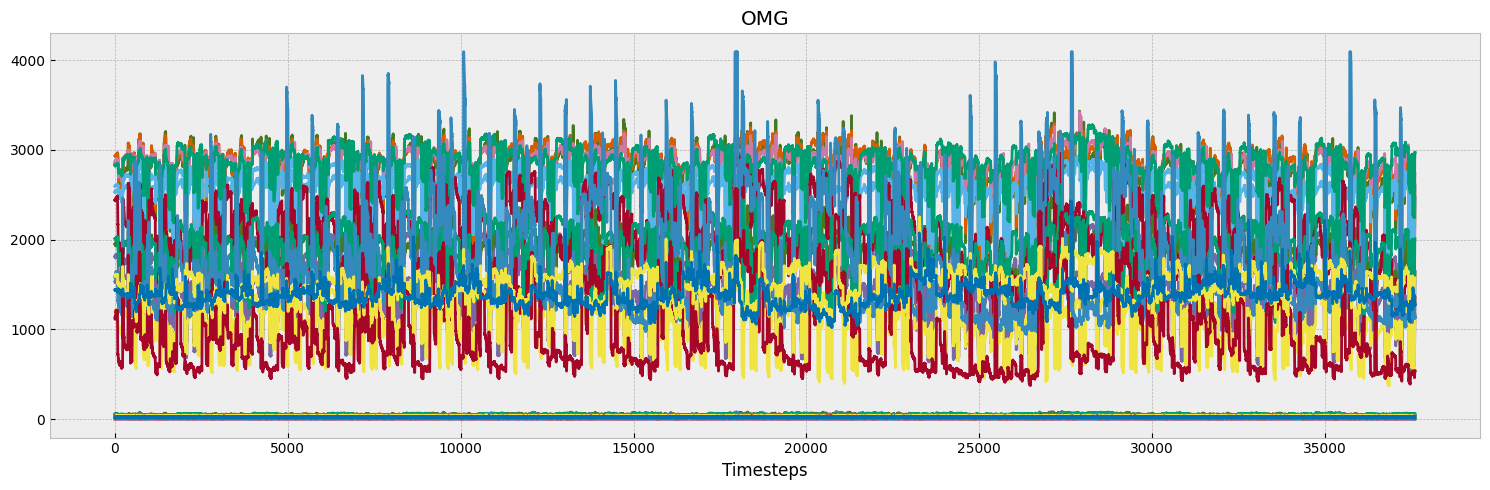

In [7]:
fig = plt.figure(figsize=(15, 5))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

# Protocol

In [8]:
gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)

gestures_protocol

Thumb  Index  Middle  Ring  Pinky  Thumb_stretch  Index_stretch  \
epoch                                                                    
0        0.0    0.0     0.0   0.0    0.0            0.0            0.0   
1        0.0    0.0     0.0   0.0    0.0            0.0            0.0   
2        1.0    0.0     0.0   0.0    0.0            0.0            0.0   
3        1.0    1.0     1.0   1.0    1.0            0.0            0.0   
4        0.0    0.0     0.0   0.0    0.0            1.0            1.0   
...      ...    ...     ...   ...    ...            ...            ...   
302      1.0    0.0     0.0   0.0    0.0            0.0            0.0   
303      1.0    1.0     1.0   1.0    1.0            0.0            0.0   
304      0.0    0.0     0.0   0.0    0.0            1.0            1.0   
305      1.0    1.0     0.0   0.0    0.0            0.0            0.0   
306      0.0    0.0     1.0   1.0    1.0            0.0            0.0   

       Middle_stretch  Ring_stretch  Pinky_stretch  Pronation  
epoch                                                          
0                 0.0           0.0            0.0        0.0  
1                 0.0           0.0            0.0        0.0  
2                 0.0           0.0            0.0        0.0  
3                 0.0           0.0            0.0        0.0  
4                 1.0           1.0            1.0        0.0  
...               ...           ...            ...        ...  
302               0.0           0.0            0.0        1.0  
303               0.0           0.0            0.0        1.0  
304               1.0           1.0            1.0        1.0  
305               0.0           0.0            0.0        1.0  
306               0.0           0.0            0.0        1.0  

[307 rows x 11 columns]

In [9]:
le = pp.LabelEncoder()

# FIT & TRANSFORM
gestures_protocol['gesture'] = le.fit_transform(
    gestures_protocol[[
        "Thumb", "Index", "Middle", "Ring", "Pinky",
        'Thumb_stretch', 'Index_stretch', 'Middle_stretch', 'Ring_stretch', 'Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

display(np.c_[le.transform(le.classes_), le.classes_])

gestures_protocol['gesture']

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

epoch
0      0
1      0
2      3
3      5
4      1
      ..
302    3
303    5
304    1
305    4
306    2
Name: gesture, Length: 307, dtype: int32

In [10]:
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
NUM_G = len(GESTURES)

GESTURES, NUM_G

(['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab'], 6)

In [11]:
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

y_cmd, len(y_cmd)

(array([0, 0, 0, ..., 0, 0, 0]), 37608)

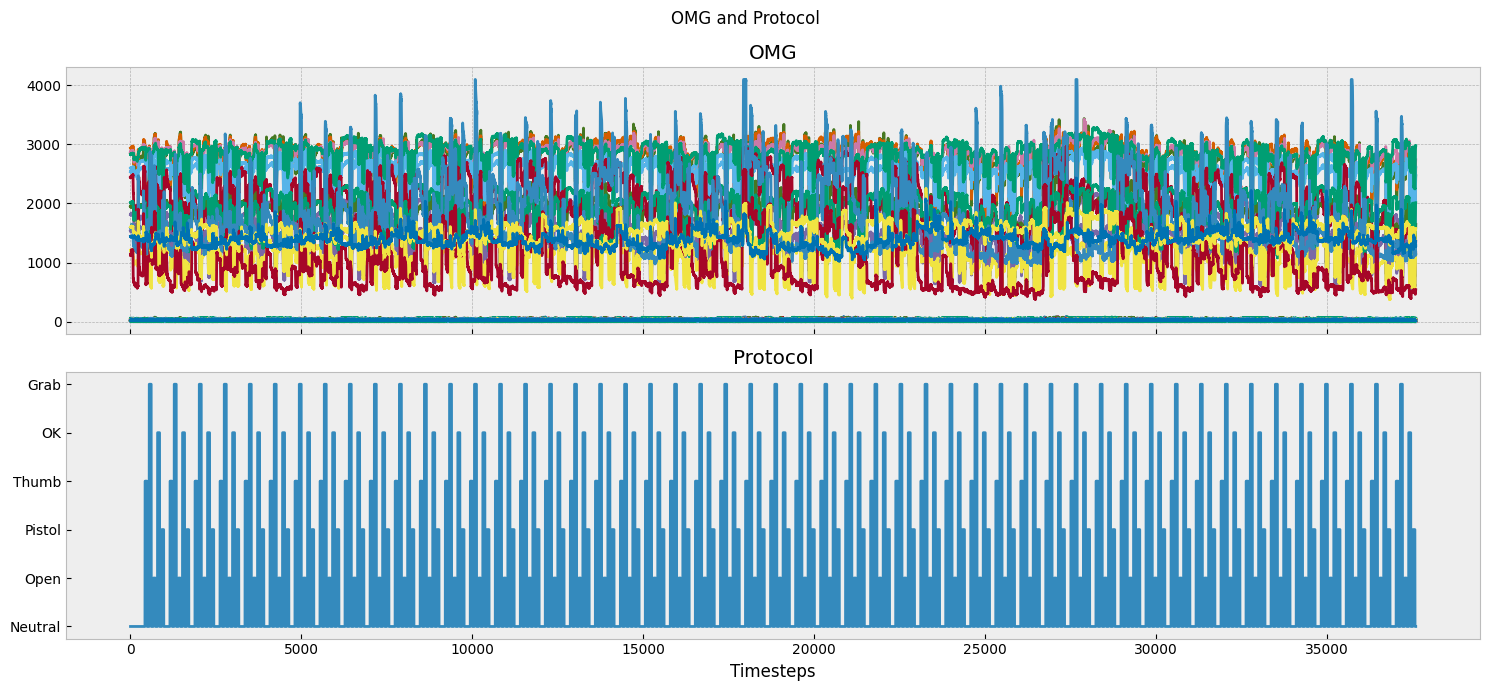

In [12]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(15, 7))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

# Preprocessing (general)

In [13]:
gestures_omg_ch = gestures[OMG_CH]

gestures_omg_ch

0  1   2     3     4     5     6   7   8   9  ...  40  41  42  43  44  \
0      10  8  28  2846  2931  2873  2597  24   8  13  ...  32  28  10  11   8   
1      16  8  29  2847  2930  2875  2598  24   8   6  ...  33  31  10  12   8   
2      10  8  29  2847  2930  2875  2598  25   8   5  ...  11  30  11  12   8   
3       0  8  29  2845  2927  2870  2594  24   8   6  ...  33  32  10  12   0   
4       9  8  25  2851  2933  2877  2599  24   8   6  ...  32  29  10  11   6   
...    .. ..  ..   ...   ...   ...   ...  ..  ..  ..  ...  ..  ..  ..  ..  ..   
37603  10  5  17  2369  2498  2677  2425  20   8   5  ...  28  25  10  10   7   
37604  10  7  21  2400  2529  2697  2441  21  17   6  ...  30  24  10  10   7   
37605  10  6  21  2429  2557  2713  2454  19   7   5  ...  28  24  18   9   7   
37606   0  7  18  2446  2565  2720  2459  22   8   6  ...  12  26  11   8   7   
37607  10  6  18  2464  2597  2737  2472  20   8  13  ...  28  31   9   9   6   

       45  46  47  48  49  
0       5   8  13  32  25  
1       5   9  14  36  28  
2       7   8  14  36  28  
3       6  10  14  36  28  
4       5   9  13  33  33  
...    ..  ..  ..  ..  ..  
37603   6   9  13  34  24  
37604   5   8  11  35  25  
37605   5   9  13  33  25  
37606   6   9  15  36  27  
37607   5   7  13  32  24  

[37608 rows x 50 columns]

In [14]:
def binarise_y(y):
    y_bin = pd.Series(y).apply(
        lambda x: 1 if x != 0 else x
    )

    return y_bin

### Shifting

Best shifting value: -16


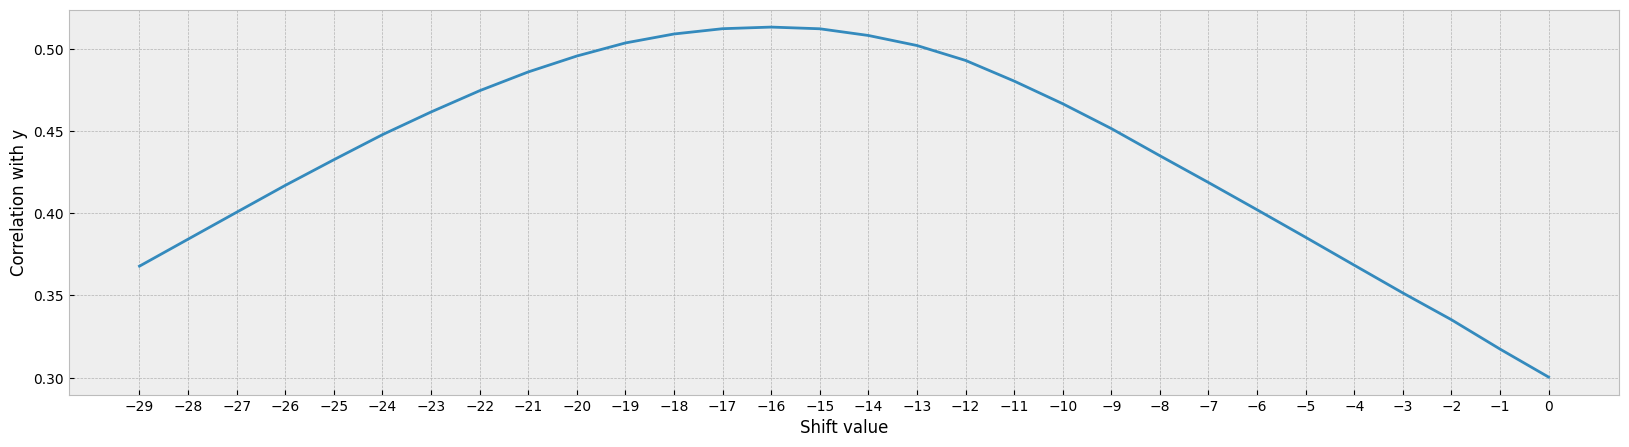

In [15]:
def select_shift(data, targ=y_cmd, plot=False):
    shift_corr = pd.Series() 
    
    scaler = pp.StandardScaler()
    data_scaled = scaler.fit_transform(data) 
    
    temp = pd.DataFrame(data_scaled).abs()  
    temp['disp'] = temp.sum(axis=1)
    
    t_bin = binarise_y(targ)
    
    for shift_value in range(0, -30, -1):  
        shifted_temp = temp.shift(shift_value).fillna(temp.median())
        
        shift_corr.loc[shift_value] = shifted_temp['disp'].corr(t_bin)
    
    best_shift = shift_corr.sort_values(ascending=False).index[0]
    
    if plot:
        print('Best shifting value:', best_shift)
        
        plt.figure(figsize=(20, 5))
        sns.lineplot(shift_corr)

        plt.xticks(range(0, -30, -1))
        plt.xlabel('Shift value')
        plt.ylabel('Correlation with y')
        plt.show()
    else:
        return best_shift


select_shift(gestures_omg_ch, plot=True)

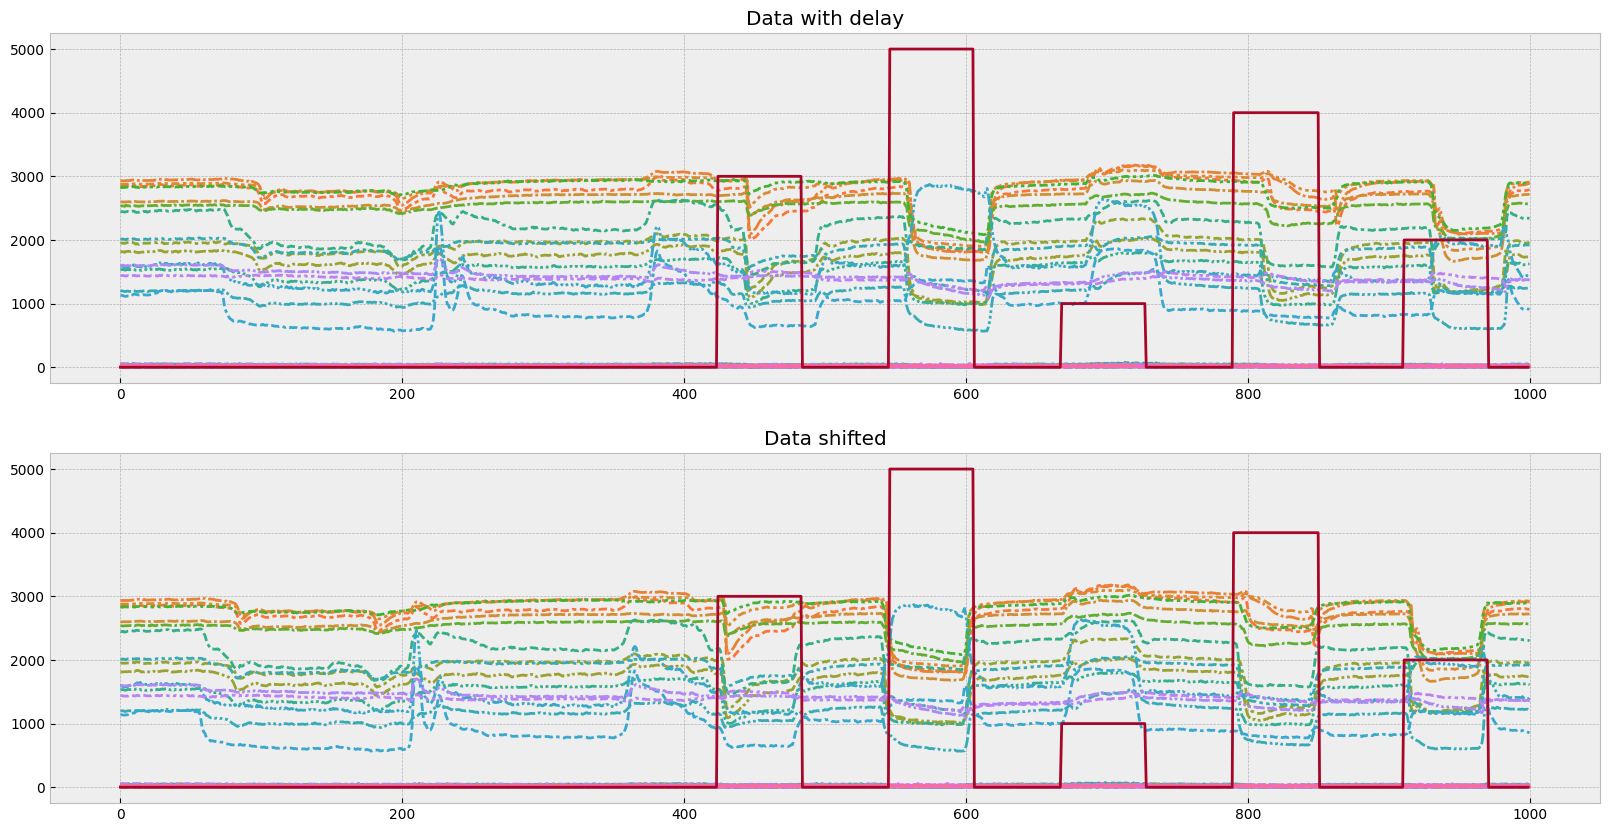

In [16]:
shift_data = lambda data, shift: data.shift(shift).fillna(0)


fig, ax = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(gestures_omg_ch.loc[:1000], 
             legend=False, 
             ax=ax[0])
sns.lineplot(y_cmd[:1000]*1000, ax=ax[0])
ax[0].set_title('Data with delay')


best_shift = select_shift(gestures_omg_ch)
gestures_shifted = shift_data(gestures_omg_ch, best_shift)

sns.lineplot(gestures_shifted.loc[:1000], 
             legend=False, 
             ax=ax[1])
sns.lineplot(y_cmd[:1000]*1000, ax=ax[1])
ax[1].set_title('Data shifted')


fig.show()

### Feature selection

Best features: ['2', '3', '4', '5', '6', '7', '11', '12', '13', '14', '15', '16', '17', '18', '21', '22', '23', '26', '27', '28', '29']


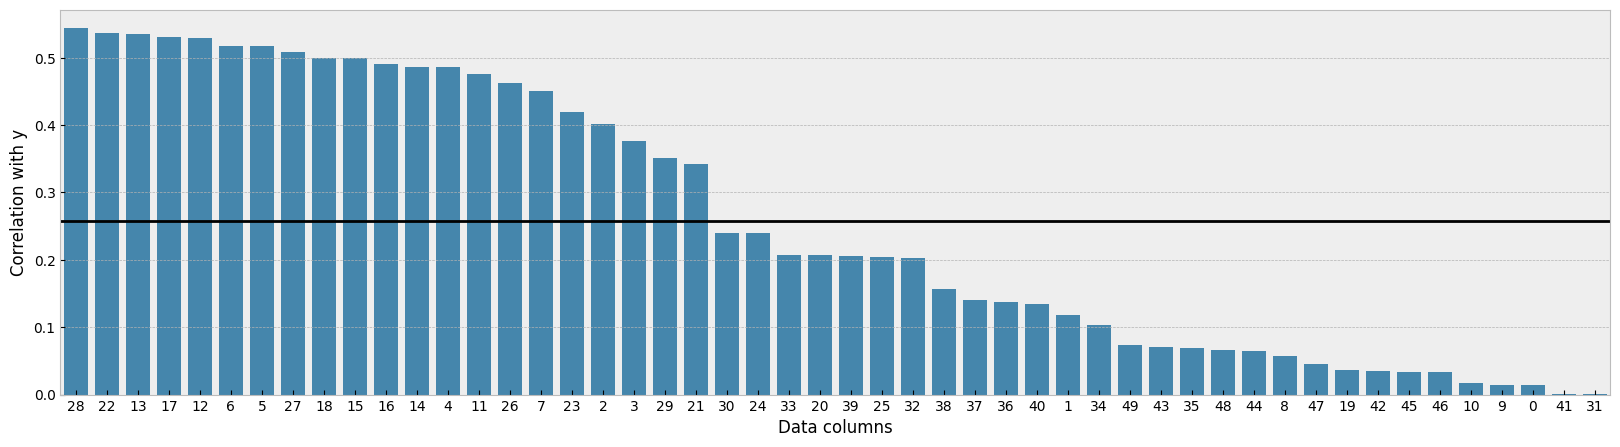

In [17]:
def select_features(data, targ=y_cmd, plot=False):
    noise_corr = pd.Series()
    
    t_bin = binarise_y(targ)

    for col in OMG_CH:    
        correlation = data[col].corr(t_bin)
        noise_corr.loc[col] = abs(correlation)

    best_cols = (
        noise_corr
        [noise_corr >= noise_corr.mean()]
        .index.tolist()
    )
    
    if plot:
        print('Best features:', best_cols)
        
        plt.figure(figsize=(20, 5))
        sns.barplot(noise_corr.sort_values(ascending=False))
        plt.axhline(noise_corr.mean(), color='black')

        plt.xlabel('Data columns')
        plt.ylabel('Correlation with y')
        plt.show()
    else:
        return best_cols


select_features(gestures_shifted, plot=True)

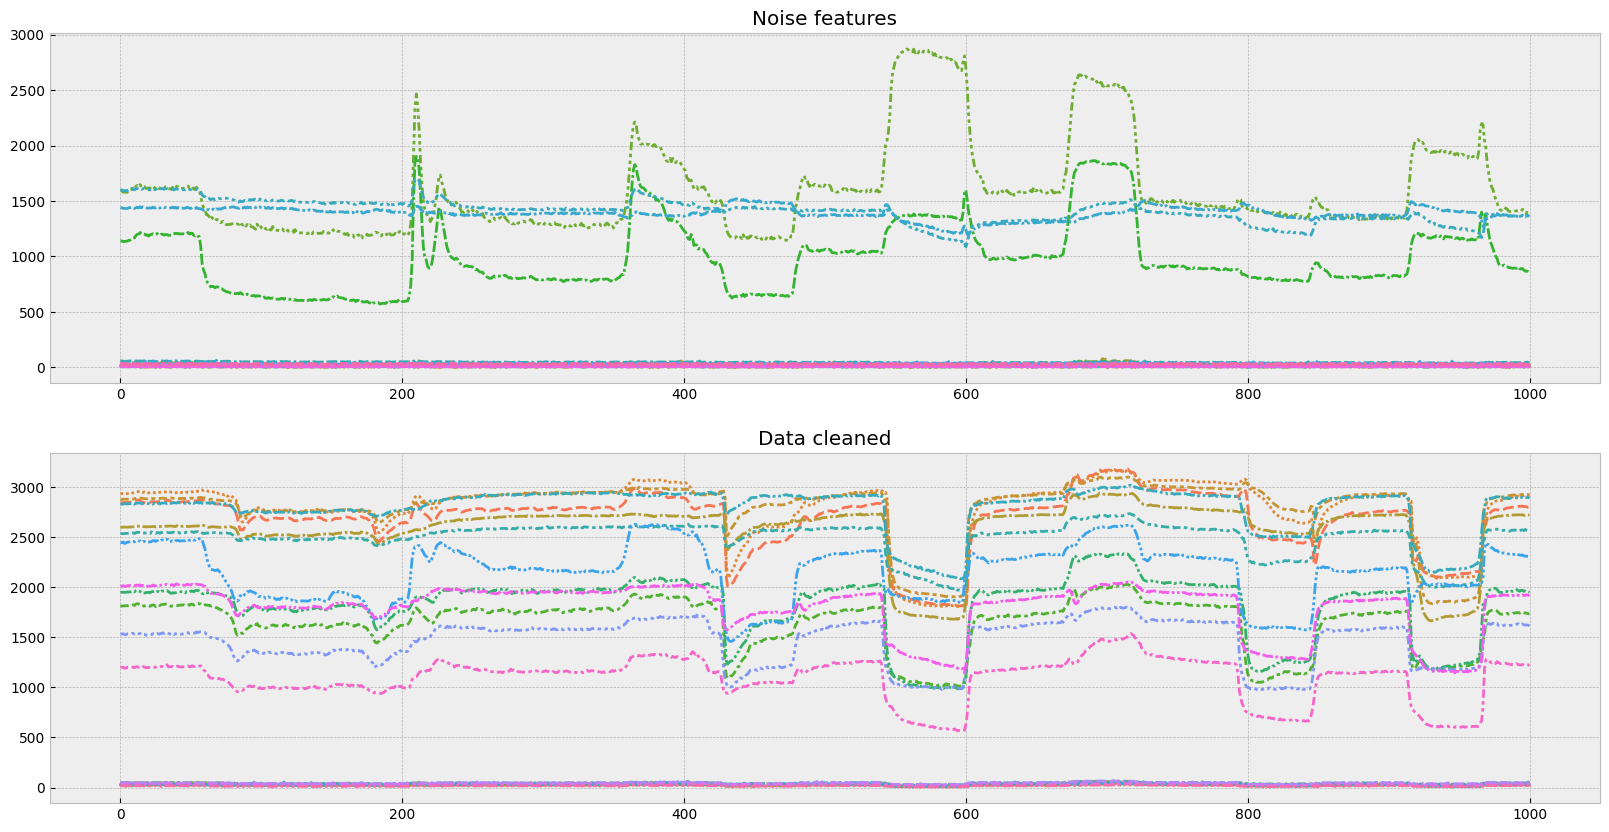

In [18]:
best_cols = select_features(gestures_shifted)

noisy_cols = gestures_shifted.drop(best_cols, axis=1).columns


fig, ax = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(gestures_shifted.loc[:1000, noisy_cols], 
             legend=False, 
             ax=ax[0])
ax[0].set_title('Noise features')


gestures_selected = gestures_shifted[best_cols]

sns.lineplot(gestures_selected.loc[:1000], 
             legend=False, 
             ax=ax[1])
ax[1].set_title('Data cleaned')


fig.show()

# Preprocessing (separate)

### Train-test split

In [19]:
df_meta = pd.read_csv('./data/meta_information.csv', index_col=0)
df_meta 

montage  pilote_id  last_train_idx  \
0                  2023-05-15_16-16-08.palm          1           23337   
1                  2023-05-15_17-12-24.palm          1           23336   
2                  2023-06-05_16-12-38.palm          1           17939   
3                  2023-06-05_17-53-01.palm          1           17771   
4                  2023-06-20_14-43-11.palm          1           17936   
5                  2023-06-20_13-30-15.palm          1           17928   
6                  2023-06-20_12-34-17.palm          1           17758   
7                  2023-09-30_08-06-44.palm          2            5693   
8                  2023-09-29_11-03-50.palm          2            5694   
9                  2023-09-29_09-20-47.palm          2            5690   
10                 2023-09-13_22-14-05.palm          2            2769   
11                 2023-09-12_14-59-23.palm          2            2759   
12                 2023-09-12_12-55-22.palm          2            2760   
13                 2023-05-31_17-14-41.palm          2           15679   
14                 2023-05-31_15-46-37.palm          2           15676   
15                 2023-05-22_20-22-01.palm          2           15602   
16                 2023-05-22_17-04-29.palm          2           23289   
17                 2023-05-19_12-04-02.palm          2           23297   
18  2023-04-18_19-08-47 gestures train.palm          3           29532   
19                 2023-05-07_16-54-27.palm          3            5747   
20                 2023-05-07_15-19-05.palm          3            5361   
21                 2023-05-12_19-17-00.palm          3           13506   
22                 2023-05-05_17-57-30.palm          4           20756   
23                 2023-10-25_11-08-46.palm          2            3539   
24         patched_2023-10-25_09-44-02.palm          2            5675   
25                 2023-10-25_08-52-30.palm          2            5674   
26                 2023-10-23_16-23-02.palm          2            5675   
27                 2023-10-23_14-07-13.palm          2            5675   
28                 2023-10-23_10-11-45.palm          2            5677   
29                 2023-10-18_08-05-29.palm          2            5681   
30                 2023-10-18_11-16-21.palm          2            5677   

    len(train)  len(test)  
0        23337       5810  
1        23336       5803  
2        17939       4431  
3        17771       4435  
4        17936       4441  
5        17928       4435  
6        17758       4444  
7         5693       5509  
8         5694       5511  
9         5690       5507  
10        2769       2951  
11        2759       2944  
12        2760       2944  
13       15679       3891  
14       15676       3892  
15       15602       3872  
16       23289       5796  
17       23297       5795  
18       29532       8078  
19        5747       5569  
20        5361       5884  
21       13506       3333  
22       20756       5894  
23        3539       3427  
24        5675       5496  
25        5674       5496  
26        5675       5495  
27        5675       5496  
28        5677       5498  
29        5681       5503  
30        5677       5499

In [20]:
def train_test_split(palm_file, X, y):
    palm_mask = df_meta['montage'] == palm_file.split('/')[-1]
    
    last_train_idx = df_meta[palm_mask]['last_train_idx'].values[0]
    pilote_id = df_meta[palm_mask]['pilote_id'].values[0]
    
    X_train = X.loc[:last_train_idx-1]
    y_train = y[:last_train_idx]

    X_test = X.loc[last_train_idx:]
    y_test = y[last_train_idx:]
    
    return (X_train, X_test, 
            y_train, y_test, 
            last_train_idx, pilote_id) 


X_train, X_test, y_train, y_test = train_test_split(palm_file, gestures_selected, y_cmd)[:4]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(29532, 21) (29532,)
(8076, 21) (8076,)


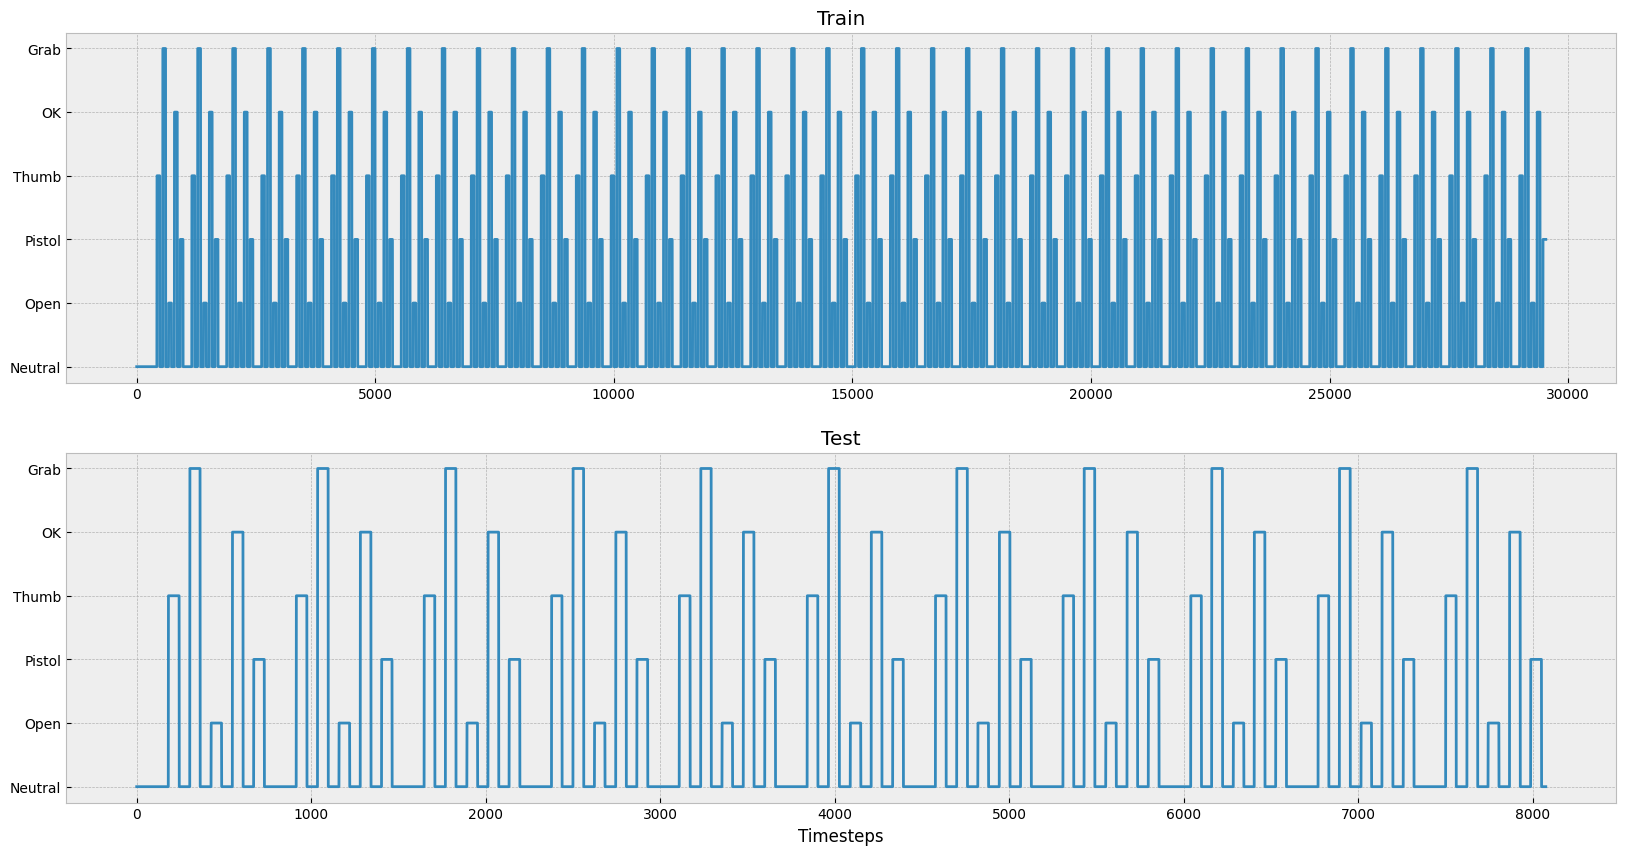

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(y_train, ax=ax[0])
sns.lineplot(y_test, ax=ax[1])

ax[0].set_yticks(range(len(GESTURES)), GESTURES)
ax[0].set_title('Train')

ax[1].set_xlabel('Timesteps')
ax[1].set_yticks(range(len(GESTURES)), GESTURES)
ax[1].set_title('Test')

fig.show()

### Scaling

In [22]:
def scale_data(X_train, X_test):
    cols = X_train.columns
    
    scaler = pp.StandardScaler()
    scaler.fit(X_train)

    X_train_scaled = pd.DataFrame(
        scaler.transform(X_train), 
        columns=cols
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=cols
    )
    
    return X_train_scaled, X_test_scaled

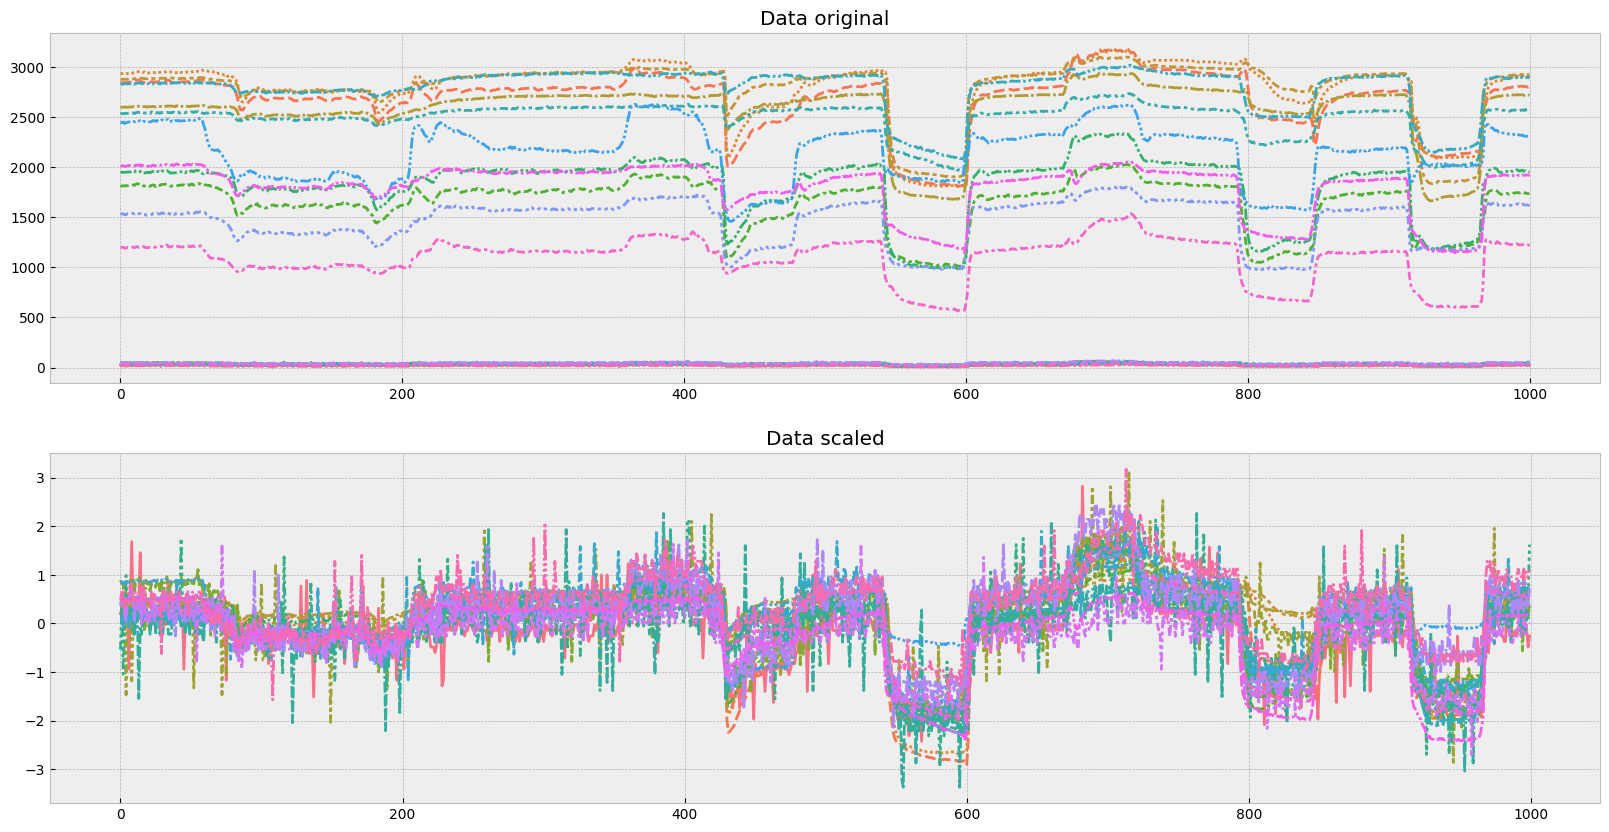

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))


sns.lineplot(X_train.loc[:1000], 
             legend=False, 
             ax=ax[0])
ax[0].set_title('Data original')


X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

sns.lineplot(X_train_scaled.iloc[:1000], 
             legend=False, 
             ax=ax[1])
ax[1].set_title('Data scaled')


fig.show() 

### Smoothing

Best window value: 1


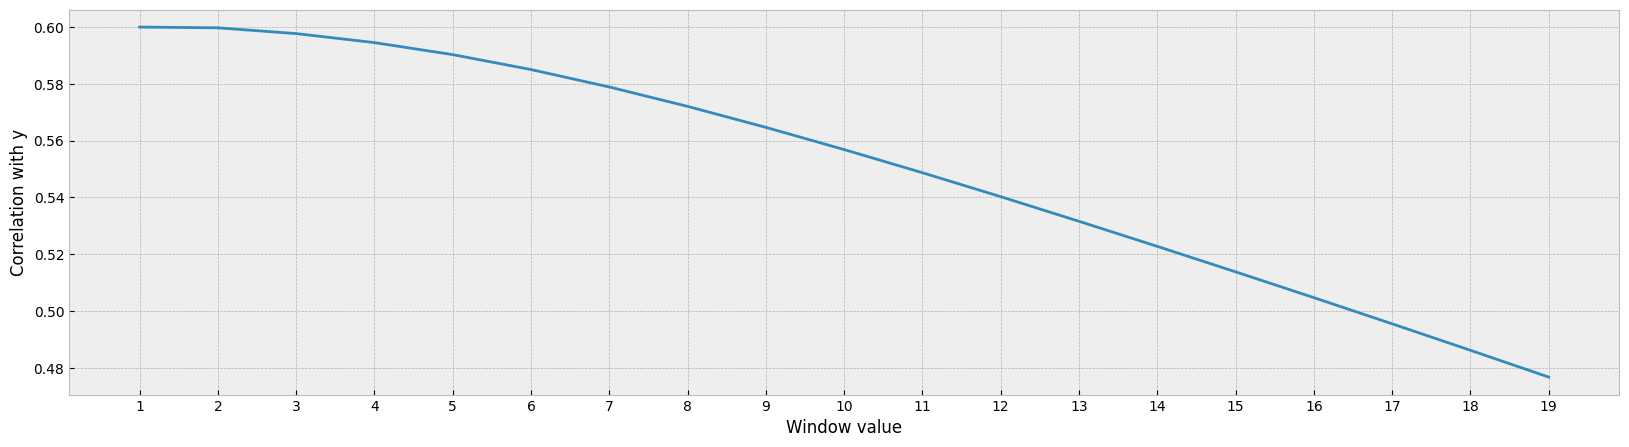

In [24]:
def select_window(data, targ, plot=False):
    smooth_corr = pd.Series()
    
    t_bin = binarise_y(targ)

    for win_value in range(1, 20):      
        smoothed_temp = data.rolling(win_value, 1).sum()
        smoothed_disp = smoothed_temp.abs().sum(axis=1)
        
        smooth_corr.loc[win_value] = smoothed_disp.corr(t_bin)
        
    best_win = smooth_corr.sort_values(ascending=False).index[0]
        
    if plot:
        print('Best window value:', best_win)
        
        plt.figure(figsize=(20, 5))
        sns.lineplot(smooth_corr)
        
        plt.xticks(range(1, 20))
        plt.xlabel('Window value')
        plt.ylabel('Correlation with y')
        plt.show()
    else:
        return best_win


select_window(X_train_scaled, y_train, plot=True)

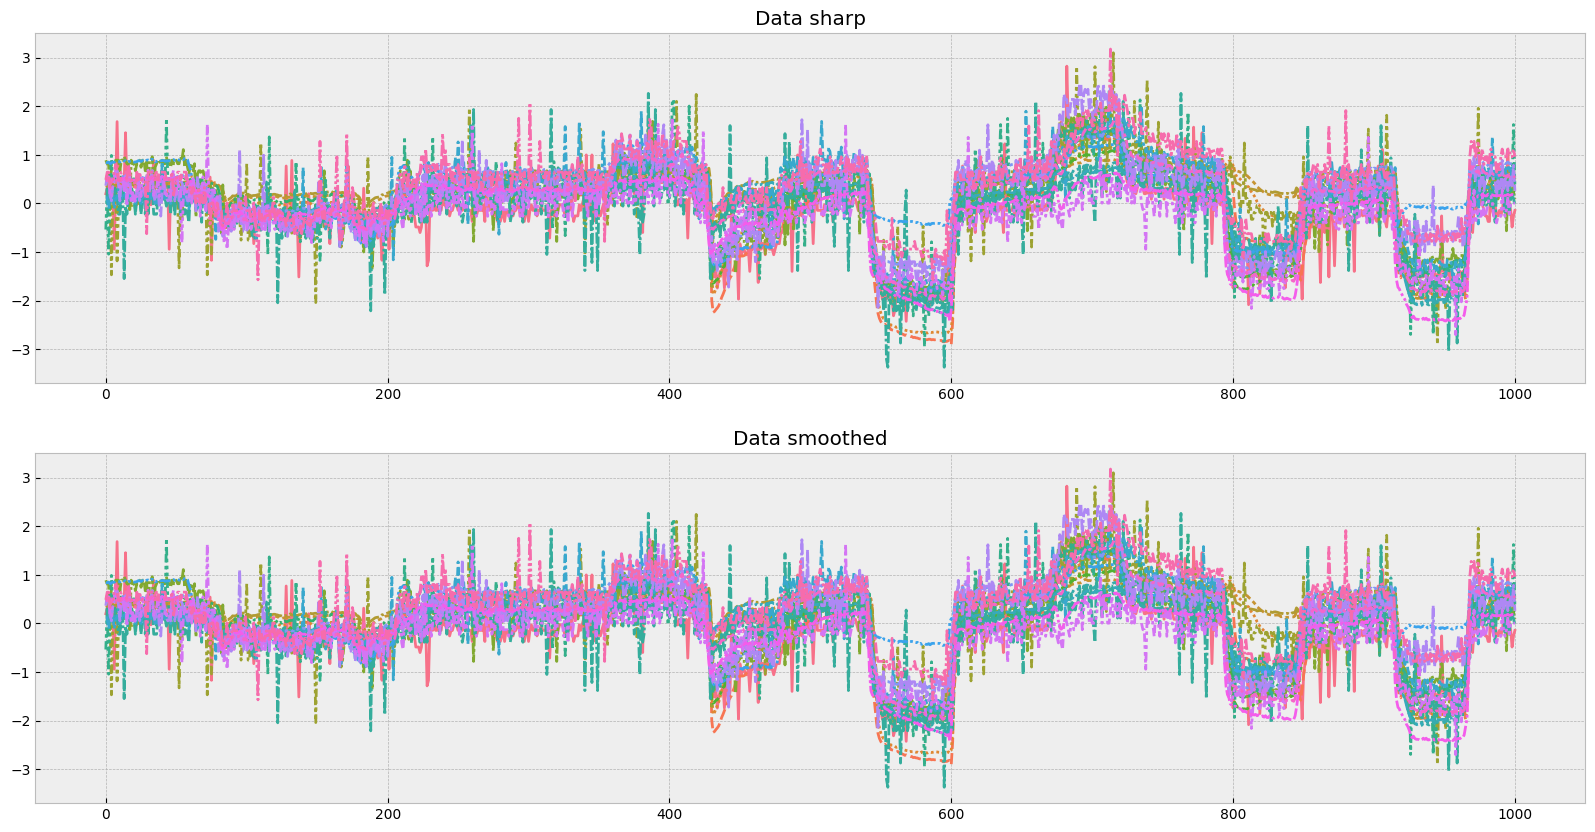

In [25]:
smoothe_data = lambda X, win: X.rolling(win, 1).sum()


fig, ax = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(X_train_scaled.loc[:1000], 
             legend=False, 
             ax=ax[0])
ax[0].set_title('Data sharp')


best_win = select_window(X_train_scaled, y_train)

X_train_smoothed = smoothe_data(X_train_scaled, best_win)
X_test_smoothed = smoothe_data(X_test_scaled, best_win)

sns.lineplot(X_train_smoothed.loc[:1000], 
             legend=False, 
             ax=ax[1])
ax[1].set_title('Data smoothed')


fig.show()

In [26]:
'''
def clean_data(X, y=y_cmd):
    X_y = pd.concat([X, pd.Series(y, name='y')], axis=1)

    for g in range(NUM_G):
        gest_X = X_y[X_y['y'] == g]
        
        gest_X['out'] = (IForest(random_state=RS)
                         .fit_predict(gest_X, y))

        i_out = gest_X[gest_X['out'] == 1].index
        
        X_y.drop(i_out, axis=0, inplace=True)
    
    y_cl = X_y.pop('y').values
    X_cl = X_y.reset_index(drop=True)
    
    return X_cl, y_cl
    
'''

"\ndef clean_data(X, y=y_cmd):\n    X_y = pd.concat([X, pd.Series(y, name='y')], axis=1)\n\n    for g in range(NUM_G):\n        gest_X = X_y[X_y['y'] == g]\n        \n        gest_X['out'] = (IForest(random_state=RS)\n                         .fit_predict(gest_X, y))\n\n        i_out = gest_X[gest_X['out'] == 1].index\n        \n        X_y.drop(i_out, axis=0, inplace=True)\n    \n    y_cl = X_y.pop('y').values\n    X_cl = X_y.reset_index(drop=True)\n    \n    return X_cl, y_cl\n    \n"

### Sample cleaning

In [27]:
def get_clips(X, y):
    X_y = pd.concat([X, pd.Series(y, name='y')], axis=1)
    
    gest_dict = {}
    
    for g in range(NUM_G):
        X_gest = X[X_y['y'] == g]

        gest_dict[g] = (X_gest.quantile(0.1), 
                        X_gest.quantile(0.9))

    return gest_dict


def clip_data(X, y, clips):
    X_y = pd.concat([X, pd.Series(y, name='y')], axis=1)
    
    X_clipped = X.copy()
    
    for g in range(NUM_G):
        X_gest = X[X_y['y'] == g]

        left_q, right_q = clips[g]
        
        X_clipped.loc[X_gest.index] = X_clipped.clip(left_q, 
                                                     right_q, 
                                                     axis=1)

    return X_clipped

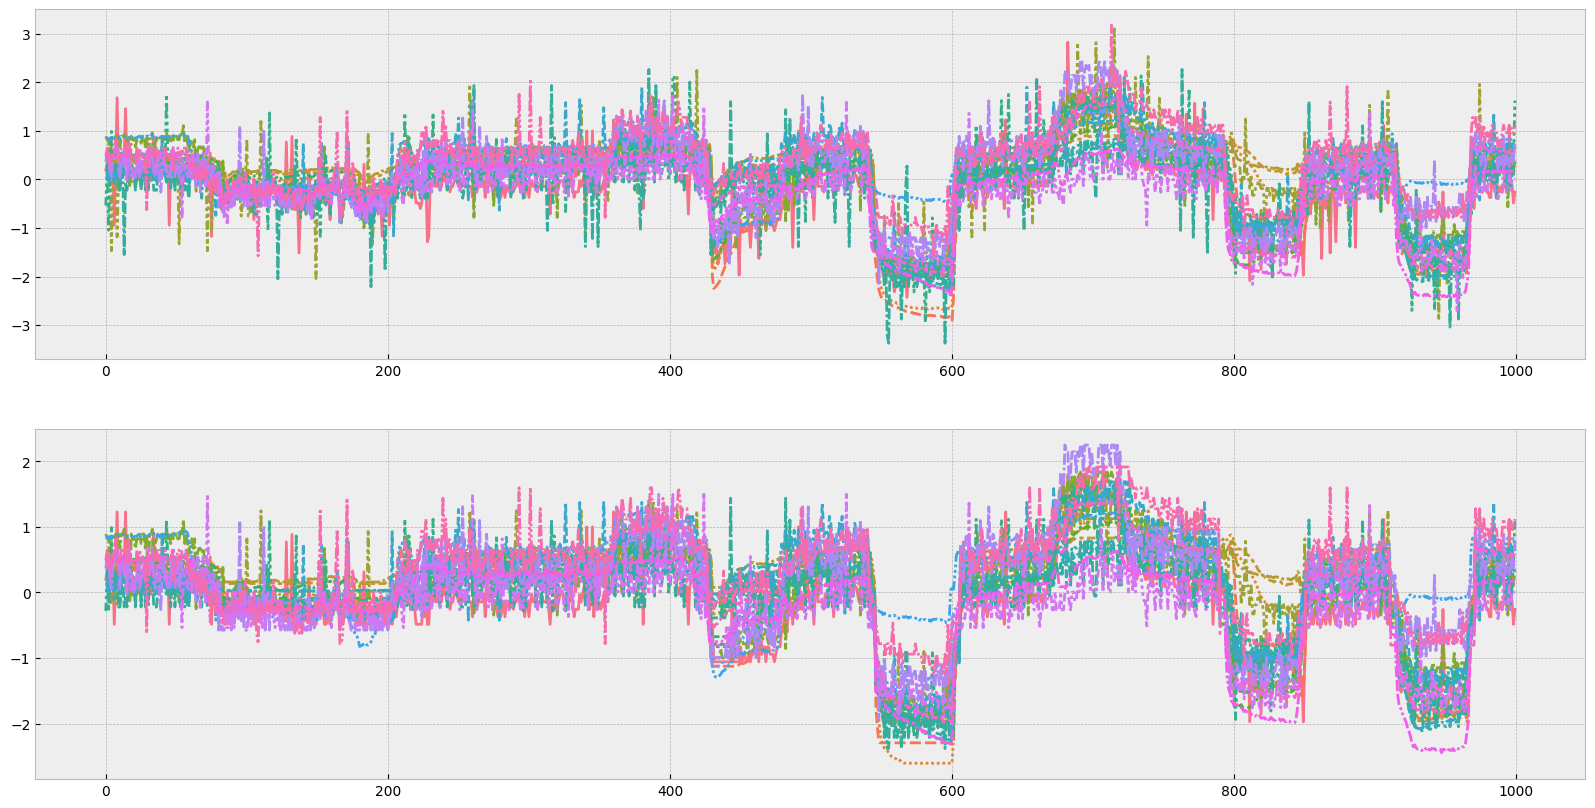

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))


sns.lineplot(X_train_smoothed.iloc[:1000], 
             legend=False, 
             ax=ax[0])
#sns.lineplot(y_train[:1000], ax=ax[0])


clips = get_clips(X_train_smoothed, y_train)

X_train_clipped = clip_data(X_train_smoothed, y_train, clips)
X_test_clipped = clip_data(X_test_smoothed, y_test, clips)


sns.lineplot(X_train_clipped.iloc[:1000], 
             legend=False, 
             ax=ax[1])
#sns.lineplot(y_train[:1000], ax=ax[1])


fig.show()

# Modeling, Prediction & Metrics

In [29]:
import catboost as cb 
import sklearn.metrics as m
import optuna
import joblib

In [30]:
Xy_set = (X_train_clipped, 
          X_test_clipped, 
          y_train, 
          y_test)


def print_error(func):
    def func_w_error(*args, **kwargs):
        try:
            func(*args, **kwargs)
        except ValueError as ve:
            print(ve)
    
    return func_w_error


def get_f1(y, y_, sample):
    class_report = m.classification_report(
        y, y_, 
        target_names=GESTURES, 
        output_dict=True
        )
    
    scores_df = (
        pd.DataFrame(class_report)
        .loc['f1-score', GESTURES]
        .rename(sample)
        )
    
    return scores_df
    

@print_error
def model_report(model, Xy_set=Xy_set):
    # FIT & PREDICT
    X_train, X_test, y_train, y_test = Xy_set
    
    if isinstance(model, cb.CatBoostClassifier):
        model.fit(
            X = X_train, 
            y = y_train, 
            eval_set = [(X_test, y_test)], 
            early_stopping_rounds = 10, 
            verbose = False
        )
        
        y_pred_train = model.predict(X_train).reshape(1, -1)[0]
        y_pred_test = model.predict(X_test).reshape(1, -1)[0]
        
    else:
        model.fit(X_train, y_train)
    
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)    

    # EVALUATE
    if ((len(np.unique(y_pred_train)) != NUM_G) or 
        (len(np.unique(y_pred_test)) != NUM_G)):
        raise ValueError('Bad prediction') 
    
    train_f1 = 100 * m.f1_score(y_train, y_pred_train, average='weighted')
    test_f1 = 100 * m.f1_score(y_test, y_pred_test, average='weighted')
    
    print(f'Train:  {round(train_f1, 1)} %')
    print(f'Test:   {round(test_f1, 1)} %')
    
    # VISUALISE
    fig, ax = plt.subplots(3, 1, figsize=(20, 15))

    train_f1_gest = get_f1(y_train, y_pred_train, 'train')
    test_f1_gest = get_f1(y_test, y_pred_test, 'test')
    scores = pd.concat([train_f1_gest, test_f1_gest], axis=1)
    
    sns.lineplot(scores, markers=True, ax=ax[0])
    
    ax[0].axhline(1, color='black')
    ax[0].axhline(0.9, color='black')
    ax[0].set_title('Scores')
    
    y_train_df = pd.DataFrame({'y_train': y_train, 'y_pred_train': y_pred_train})
    y_test_df = pd.DataFrame({'y_test': y_test, 'y_pred_test': y_pred_test})
    
    sns.lineplot(y_train_df, ax=ax[1])
    sns.lineplot(y_test_df, ax=ax[2])

    ax[1].set_yticks(range(NUM_G), GESTURES)
    ax[1].set_title('Train')

    ax[2].set_yticks(range(NUM_G), GESTURES)
    ax[2].set_title('Test')

    fig.show()   

### Baseline 

In [31]:
def opt_cat(trial: optuna.trial.Trial):
    model = cb.CatBoostClassifier(
        learning_rate = trial.suggest_float('learning_rate', 0.00001, 1), 
        depth = trial.suggest_int('depth', 2, 6),  
        iterations = 10000, 
        eval_metric='TotalF1',
        classes_count = NUM_G,
        od_type='Iter',
        random_state = RS, 
        verbose = 0, 
        allow_writing_files = False
    ).fit(
        X = X_train_clipped, 
        y = y_train, 
        eval_set = [(X_test_clipped, y_test)], 
        early_stopping_rounds = 10, 
        use_best_model = True,
        verbose = False
    )
    
    y_pred = model.predict(X_test_clipped)
    
    if len(np.unique(y_pred)) != NUM_G:
        return 0
    else:
        score = m.f1_score(y_test, y_pred, average='weighted')
        
    return score
    

study_cat = optuna.create_study(study_name='meow', direction='maximize')

study_cat.optimize(opt_cat, n_trials=50)

[I 2024-02-12 00:31:34,897] A new study created in memory with name: meow
[I 2024-02-12 00:31:38,503] Trial 0 finished with value: 0.9832960731798664 and parameters: {'learning_rate': 0.06870941177025246, 'depth': 4}. Best is trial 0 with value: 0.9832960731798664.
[I 2024-02-12 00:31:39,885] Trial 1 finished with value: 0.9851263434679807 and parameters: {'learning_rate': 0.34153341470619275, 'depth': 6}. Best is trial 1 with value: 0.9851263434679807.
[I 2024-02-12 00:31:40,482] Trial 2 finished with value: 0.9794568837487525 and parameters: {'learning_rate': 0.9329368448401244, 'depth': 3}. Best is trial 1 with value: 0.9851263434679807.
[I 2024-02-12 00:31:41,069] Trial 3 finished with value: 0.986901476993559 and parameters: {'learning_rate': 0.5098453364178759, 'depth': 3}. Best is trial 3 with value: 0.986901476993559.
[I 2024-02-12 00:31:41,433] Trial 4 finished with value: 0.9792072169306273 and parameters: {'learning_rate': 0.7210604114310747, 'depth': 2}. Best is trial 3 wit

Train:  99.7 %
Test:   98.7 %


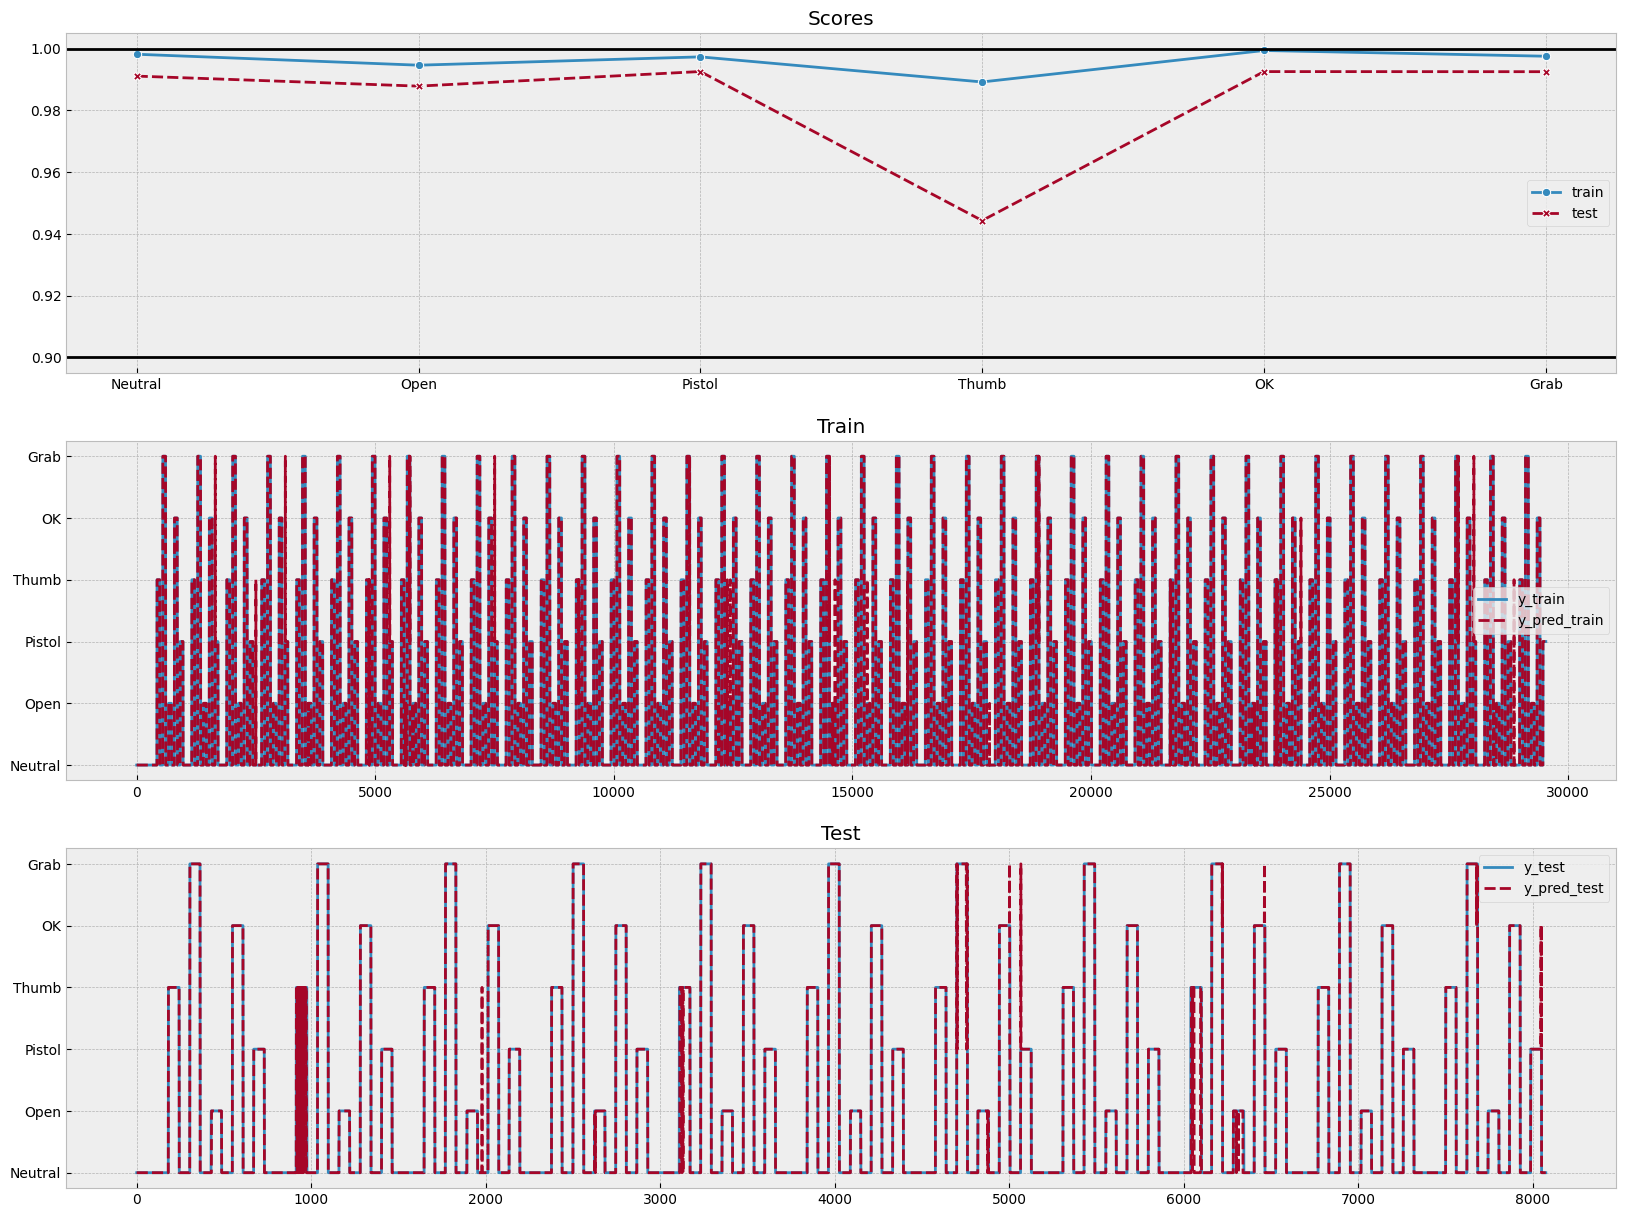

In [32]:
cat_model = cb.CatBoostClassifier(
    iterations = 10000, 
    eval_metric='TotalF1',
    classes_count = NUM_G,
    od_type='Iter',
    random_state = RS, 
    verbose = 0, 
    allow_writing_files = False
    ).set_params(**study_cat.best_params)


model_report(cat_model)

### All data scoring

In [33]:
scores_df = pd.DataFrame(
    columns=['train_score', 
             'test_score',
             'score_diff',
             'features', 
             'shift', 
             'window', 
             'split_index', 
             'pilote_id']
)


scores_df

Empty DataFrame
Columns: [train_score, test_score, score_diff, features, shift, window, split_index, pilote_id]
Index: []

In [34]:
def read_protocol_csv(palm_file, gestures):
    gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)
    
    le = pp.LabelEncoder()

    gestures_protocol['gesture'] = le.fit_transform(
        gestures_protocol[[
            "Thumb", "Index", "Middle", "Ring", "Pinky",
            'Thumb_stretch', 'Index_stretch', 'Middle_stretch', 'Ring_stretch', 'Pinky_stretch'
        ]]
        .apply(lambda row: str(tuple(row)), axis=1)
    )
    
    y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
    
    return y_cmd

In [35]:
for i, data in enumerate(data_names):
    # READ DATA
    palm_file = './data/' + data
    gestures = read_omg_csv(palm_file, 
                            n_omg_channels=50,
                            n_acc_channels=3, 
                            n_gyr_channels=3, 
                            n_enc_channels=6, 
                            n_mag_channels=0)

    y_cmd = read_protocol_csv(palm_file, gestures)


    # SHIFTING
    gestures_omg_ch = gestures[OMG_CH]
    
    best_shift = select_shift(gestures_omg_ch, y_cmd)
    gestures_shifted = shift_data(gestures_omg_ch, best_shift)
    
    scores_df.loc[data, 'shift'] = best_shift
    
    
    # FEATURE CLEANING
    best_cols = select_features(gestures_shifted, y_cmd)
    gestures_selected = gestures_shifted[best_cols]
    
    scores_df.loc[data, 'features'] = best_cols
    
    
    # TRAIN TEST SPLIT
    data_splitted = train_test_split(palm_file, gestures_selected, y_cmd)
    
    X_train, X_test, y_train, y_test = data_splitted[:4]
    
    scores_df.loc[data, 'split_index'] = data_splitted[-2]
    scores_df.loc[data, 'pilote_id'] = data_splitted[-1]
    
    
    # SCALING
    X_train_scaled, X_test_scaled = scale_data(X_train, X_test)
    
    
    # SMOOTHING        
    best_win = select_window(X_train_scaled, y_train)
    
    X_train_smoothed = smoothe_data(X_train_scaled, best_win)
    X_test_smoothed = smoothe_data(X_test_scaled, best_win)
    
    scores_df.loc[data, 'window'] = best_win
    
    
    # SAMPLE CLEANING
    clips = get_clips(X_train_smoothed, y_train)

    X_train_clipped = clip_data(X_train_smoothed, y_train, clips)
    X_test_clipped = clip_data(X_test_smoothed, y_test, clips)
    
    
    # MODEL SCORING    
    cat_model.fit(
        X = X_train_clipped, 
        y = y_train, 
        eval_set = [(X_test_clipped, y_test)], 
        early_stopping_rounds = 10, 
        verbose = False
    )
    
    y_pred_train = cat_model.predict(X_train_clipped)
    y_pred_test = cat_model.predict(X_test_clipped)
    
    if ((len(np.unique(y_pred_train)) != NUM_G) or 
        (len(np.unique(y_pred_test)) != NUM_G)):
        train_f1, test_f1 = 0, 0
    else:
        train_f1 = 100 * m.f1_score(y_train, y_pred_train, average='weighted')
        test_f1 = 100 * m.f1_score(y_test, y_pred_test, average='weighted')
        
    scores_df.loc[data, 'train_score'] = round(train_f1, 1)
    scores_df.loc[data, 'test_score'] = round(test_f1, 1)
    scores_df.loc[data, 'score_diff'] = abs(round(train_f1-test_f1, 1))
    
    
    # VERBOSITY
    print(f'Session №{i} with {data} is done')

Session №0 with 2023-04-18_19-08-47 gestures train.palm is done
Session №1 with 2023-05-05_17-57-30.palm is done
Session №2 with 2023-05-07_15-19-05.palm is done
Session №3 with 2023-05-07_16-54-27.palm is done
Session №4 with 2023-05-12_19-17-00.palm is done
Session №5 with 2023-05-15_16-16-08.palm is done
Session №6 with 2023-05-15_17-12-24.palm is done
Session №7 with 2023-05-19_12-04-02.palm is done
Session №8 with 2023-05-22_17-04-29.palm is done
Session №9 with 2023-05-22_20-22-01.palm is done
Session №10 with 2023-05-31_15-46-37.palm is done
Session №11 with 2023-05-31_17-14-41.palm is done
Session №12 with 2023-06-05_16-12-38.palm is done
Session №13 with 2023-06-05_17-53-01.palm is done
Session №14 with 2023-06-20_12-34-17.palm is done
Session №15 with 2023-06-20_13-30-15.palm is done
Session №16 with 2023-06-20_14-43-11.palm is done
Session №17 with 2023-09-12_12-55-22.palm is done
Session №18 with 2023-09-12_14-59-23.palm is done
Session №19 with 2023-09-13_22-14-05.palm is 

In [36]:
scores_df.sort_values('test_score') 

train_score test_score score_diff  \
2023-10-25_11-08-46.palm                       78.0       77.7        0.4   
2023-06-05_17-53-01.palm                       91.9       90.0        1.8   
2023-06-05_16-12-38.palm                       96.6       92.2        4.4   
2023-06-20_12-34-17.palm                       95.3       93.9        1.4   
2023-05-07_15-19-05.palm                       99.8       95.3        4.5   
2023-06-20_14-43-11.palm                       95.6       95.8        0.3   
2023-10-23_16-23-02.palm                       99.9       96.1        3.9   
2023-05-15_17-12-24.palm                       92.7       96.5        3.7   
2023-10-25_08-52-30.palm                      100.0       97.0        3.0   
2023-10-18_08-05-29.palm                       98.8       97.1        1.7   
2023-09-13_22-14-05.palm                       99.8       97.2        2.5   
2023-05-07_16-54-27.palm                       99.9       97.5        2.4   
2023-10-18_11-16-21.palm                       99.9       97.9        2.1   
2023-05-31_15-46-37.palm                       99.3       97.9        1.4   
2023-09-12_14-59-23.palm                       99.9       98.3        1.6   
patched_2023-10-25_09-44-02.palm               99.9       98.5        1.5   
2023-04-18_19-08-47 gestures train.palm        99.7       98.7        1.0   
2023-09-29_11-03-50.palm                       99.9       98.9        1.0   
2023-05-15_16-16-08.palm                       99.7       98.9        0.8   
2023-05-12_19-17-00.palm                       98.9       98.9        0.1   
2023-09-30_08-06-44.palm                       99.9       99.1        0.8   
2023-10-23_10-11-45.palm                       99.9       99.1        0.8   
2023-09-12_12-55-22.palm                      100.0       99.2        0.8   
2023-06-20_13-30-15.palm                       99.5       99.3        0.3   
2023-09-29_09-20-47.palm                       98.8       99.5        0.7   
2023-05-22_20-22-01.palm                      100.0       99.6        0.4   
2023-10-23_14-07-13.palm                       99.8       99.6        0.2   
2023-05-19_12-04-02.palm                      100.0       99.7        0.2   
2023-05-22_17-04-29.palm                       99.6       99.9        0.3   
2023-05-31_17-14-41.palm                       99.6       99.9        0.3   
2023-05-05_17-57-30.palm                       99.9      100.0        0.1   

                                                                                  features  \
2023-10-25_11-08-46.palm                 [0, 3, 4, 5, 7, 11, 12, 14, 15, 16, 17, 18, 21...   
2023-06-05_17-53-01.palm                   [3, 11, 12, 21, 22, 28, 29, 30, 31, 32, 38, 48]   
2023-06-05_16-12-38.palm                 [2, 4, 5, 6, 13, 14, 15, 16, 17, 21, 22, 26, 2...   
2023-06-20_12-34-17.palm                 [2, 3, 6, 7, 12, 13, 14, 15, 16, 21, 22, 26, 2...   
2023-05-07_15-19-05.palm                 [3, 4, 5, 6, 7, 16, 17, 18, 20, 22, 26, 27, 28...   
2023-06-20_14-43-11.palm                 [3, 4, 5, 6, 7, 13, 16, 18, 21, 29, 30, 32, 37...   
2023-10-23_16-23-02.palm                   [1, 11, 12, 17, 18, 22, 23, 26, 27, 33, 34, 36]   
2023-05-15_17-12-24.palm                 [2, 3, 4, 6, 7, 11, 12, 14, 16, 27, 28, 31, 32...   
2023-10-25_08-52-30.palm                 [0, 1, 11, 12, 17, 18, 22, 26, 27, 33, 34, 35,...   
2023-10-18_08-05-29.palm                     [0, 1, 8, 11, 12, 22, 26, 27, 33, 34, 35, 36]   
2023-09-13_22-14-05.palm                 [1, 2, 7, 9, 10, 12, 18, 20, 22, 23, 27, 28, 3...   
2023-05-07_16-54-27.palm                 [5, 6, 12, 13, 15, 16, 17, 21, 27, 28, 30, 31,...   
2023-10-18_11-16-21.palm                 [0, 1, 8, 11, 12, 18, 22, 23, 26, 27, 34, 35, 36]   
2023-05-31_15-46-37.palm                 [12, 13, 14, 17, 21, 24, 28, 29, 30, 31, 34, 3...   
2023-09-12_14-59-23.palm                 [2, 5, 7, 8, 9, 10, 12, 15, 17, 18, 20, 22, 26...   
patched_2023-10-25_09-44-02.palm         [0, 1, 2, 7, 8, 9, 11, 12, 16,

In [37]:
scores_df[['train_score', 'test_score', 'score_diff']].mean() 

train_score    98.145161
test_score     97.070968
score_diff      1.432258
dtype: object

### *Underfitting problem 

In [40]:
bad_palm = (scores_df
            [scores_df['test_score'] < 90]
            .iloc[0])

bad_palm

train_score                                                 78.0
test_score                                                  77.7
score_diff                                                   0.4
features       [0, 3, 4, 5, 7, 11, 12, 14, 15, 16, 17, 18, 21...
shift                                                          0
window                                                         1
split_index                                                 3539
pilote_id                                                      2
Name: 2023-10-25_11-08-46.palm, dtype: object

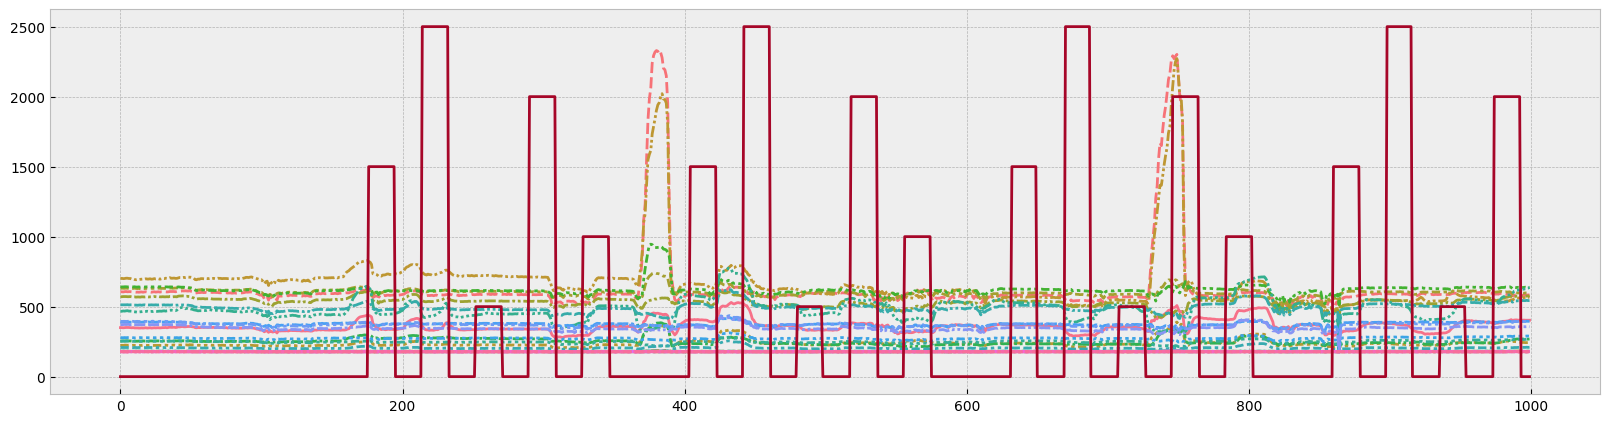

In [41]:
# DATA
bad_file = './data/'+bad_palm.name

bad_df = read_omg_csv(bad_file, 
                      n_omg_channels=50,
                      n_acc_channels=3, 
                      n_gyr_channels=3, 
                      n_enc_channels=6, 
                      n_mag_channels=0)

bad_y = read_protocol_csv(bad_file, bad_df)

bad_omg = bad_df[OMG_CH]


plt.figure(figsize=(20, 5))
sns.lineplot(bad_df[OMG_CH].iloc[:1000], legend=False)
sns.lineplot(bad_y[:1000]*500)

plt.show()

In [42]:
def preprocess_data(params, data, target):
    # SHIFTING
    shifted = shift_data(data, params.loc['shift'])
    
    # FEATURE CLEANING
    selected = shifted[params.loc['features']]
    
    # TRAIN TEST SPLIT
    last_train_idx = params.loc['split_index']

    X_train = selected.loc[:last_train_idx-1]
    y_train = target[:last_train_idx]

    X_test = selected.loc[last_train_idx:]
    y_test = target[last_train_idx:]

    # SCALING
    X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

    # SMOOTHING
    X_train_smoothed = smoothe_data(X_train_scaled, params.loc['window'])
    X_test_smoothed = smoothe_data(X_test_scaled, params.loc['window'])

    # SAMPLE CLEANING
    clips = get_clips(X_train_smoothed, y_train)

    X_train_clipped = clip_data(X_train_smoothed, y_train, clips)
    X_test_clipped = clip_data(X_test_smoothed, y_test, clips)
    
    return X_train_clipped, X_test_clipped, y_train, y_test

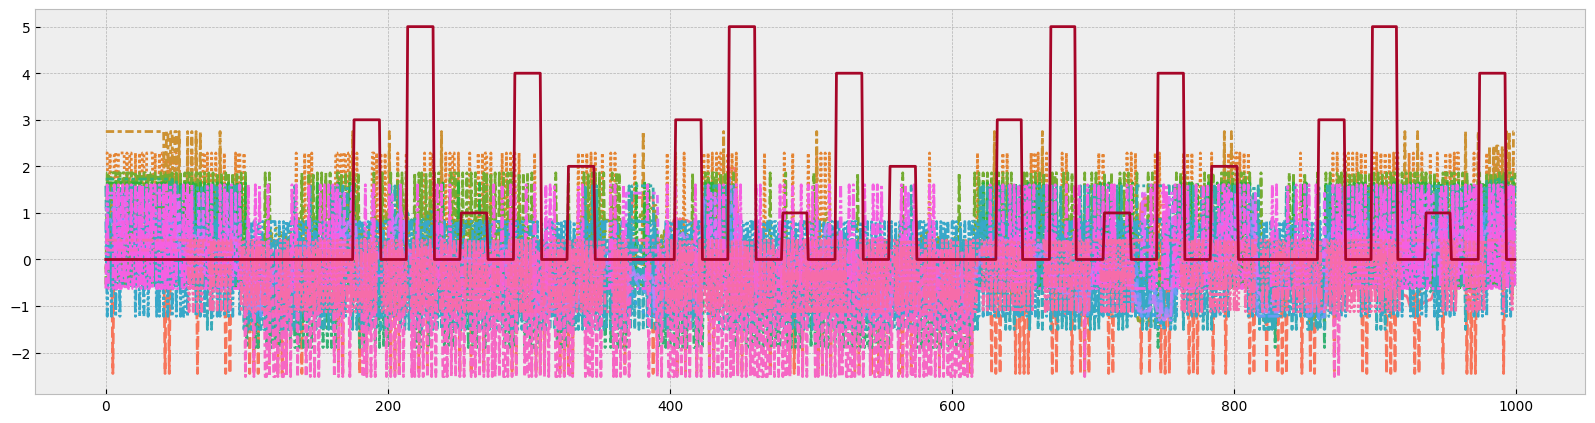

In [43]:
X_train, X_test, y_train, y_test = preprocess_data(bad_palm, bad_omg, bad_y)


plt.figure(figsize=(20, 5))

sns.lineplot(X_train.iloc[:1000], legend=False)
sns.lineplot(bad_y[:1000])

plt.show()

Train:  78.0 %
Test:   77.7 %


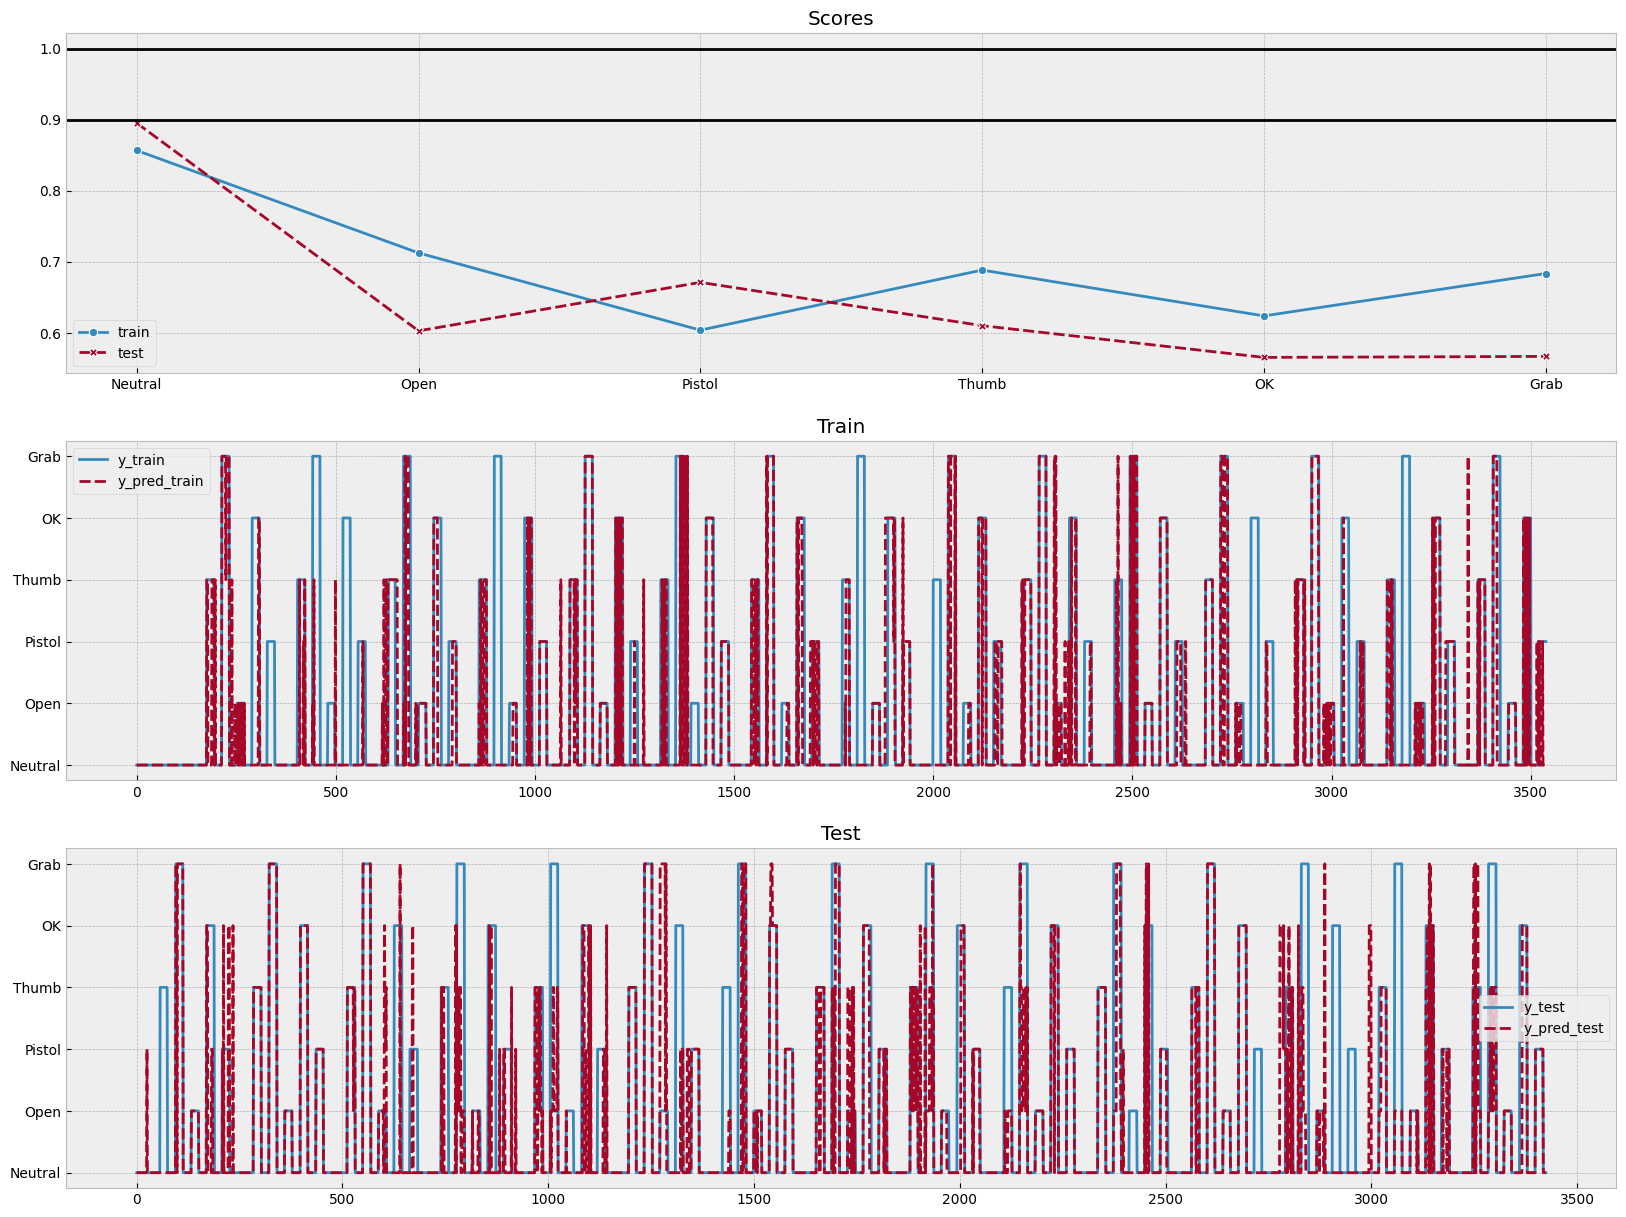

In [44]:
model_report(cat_model, Xy_set=(X_train, X_test, y_train, y_test)) 

In [45]:
def opt_cat(trial: optuna.trial.Trial):
    model = cb.CatBoostClassifier(
        learning_rate = trial.suggest_float('learning_rate', 0.00001, 1), 
        depth = trial.suggest_int('depth', 2, 6),  
        iterations = 10000, 
        eval_metric='TotalF1',
        classes_count = NUM_G,
        od_type='Iter',
        random_state = RS, 
        verbose = 0, 
        allow_writing_files = False
    ).fit(
        X = X_train, 
        y = y_train, 
        eval_set = [(X_test, y_test)], 
        early_stopping_rounds = 10, 
        use_best_model = True,
        verbose = False
    )
    
    y_pred = model.predict(X_test)
    
    if len(np.unique(y_pred)) != NUM_G:
        return 0
    else:
        score = m.f1_score(y_test, y_pred, average='weighted')
        
    return score
    

study_cat = optuna.create_study(study_name='meow', direction='maximize')

study_cat.optimize(opt_cat, n_trials=50)

[I 2024-02-12 00:37:38,909] A new study created in memory with name: meow
[I 2024-02-12 00:37:39,184] Trial 0 finished with value: 0.7704678252578065 and parameters: {'learning_rate': 0.31560546026565955, 'depth': 6}. Best is trial 0 with value: 0.7704678252578065.
[I 2024-02-12 00:37:39,290] Trial 1 finished with value: 0.7922295721613192 and parameters: {'learning_rate': 0.4404510343024233, 'depth': 2}. Best is trial 1 with value: 0.7922295721613192.
[I 2024-02-12 00:37:39,417] Trial 2 finished with value: 0.7774217254007666 and parameters: {'learning_rate': 0.5818861136432165, 'depth': 4}. Best is trial 1 with value: 0.7922295721613192.
[I 2024-02-12 00:37:39,650] Trial 3 finished with value: 0.0 and parameters: {'learning_rate': 0.023152189736407546, 'depth': 3}. Best is trial 1 with value: 0.7922295721613192.
[I 2024-02-12 00:37:39,734] Trial 4 finished with value: 0.0 and parameters: {'learning_rate': 0.16230478831021908, 'depth': 3}. Best is trial 1 with value: 0.792229572161319

# Save best model

In [46]:
model_path = './models/CatBoost_GesturesClassifier.pkl'
joblib.dump(cat_model, model_path)

print(joblib.load(model_path), f'\nSaved at {model_path}')

Saved at ./models/CatBoost_GesturesClassifier.pkl


-----

# Real-time inference

In [64]:
import time
import serial 
from IPython.display import clear_output

In [65]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
]

    
def get_crc(data, count):
    result = 0x00
    l = count
    
    while count > 0:   
        result = crc_table[result ^ data[l-count]]
        count -= 1
        
    return result


def drv_abs_one(ser, control):
    if ser is None:
        return
    
    pack = np.array(([80, 0x01, 0xBB, 6] + 
                     [c for c in control] + 
                     [0]), 
                    dtype='uint8')
    pack[-1] = get_crc(pack[1:], 9)
    
    return pack, ser.write(bytearray(pack))

## Inference Utils: Put your code here

In [66]:
#model_path = './models/CatBoost_GesturesClassifier.pkl' #SVC_2023-04-18_19-08-47 gestures train.pkl
model = joblib.load(model_path)

print(type(model))

model.get_params()

<class 'catboost.core.CatBoostClassifier'>


{'iterations': 10000,
 'od_type': 'Iter',
 'verbose': 0,
 'classes_count': 6,
 'eval_metric': 'TotalF1',
 'allow_writing_files': False,
 'random_state': 8,
 'learning_rate': 0.7063845989755377,
 'depth': 3}

In [67]:
def preprocessing(x):
    # x - sample vector
    X = np.concatenate(x)
    
    return X


def inference(x):
    y = model.predict(x)
    
    return y


def postprocessing(x, prev):
    x = x.reshape(1, -1)[0]
    
    if prev is None:
        y = x
    else:
        y = (x*0.1) + (prev*0.9) # Holt-Winters filter
        
    return y


def commands(x):
    y = np.round(np.clip(x/100, 0, 1) * 100).astype(int)
    return y

## Inference

### Offline (dataset)

In [68]:
palm_file = './data/2023-04-18_19-08-47 gestures train.palm'
gestures = read_omg_csv(palm_file, 
                        n_omg_channels=50,
                        n_acc_channels=3, 
                        n_gyr_channels=3, 
                        n_enc_channels=6, 
                        n_mag_channels=0)

y_cmd = read_protocol_csv(palm_file, gestures)


last_train_idx = train_test_split(palm_file, gestures, y_cmd)[-2]
df_sim = gestures.iloc[last_train_idx:]

print(df_sim.shape)

(8076, 65)


In [70]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0

y_previous = None
y_dct = {
    'omg_sample': [],
    'enc_sample': [],
    'sample_preprocessed': [],
    'y_predicted': [],
    'y_postprocessed': [],
    'y_commands': [],
}


while True:    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < X_test.shape[0]:
            sample = df_sim.values[i]
        else:
            break
        
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
    
    # [Data preprocessing]
    y_dct['omg_sample'].append(omg_sample)
    
    sample_preprocessed = preprocessing(y_dct['omg_sample'][:10])
    
    # [Inference]
    y_predicted = inference(sample_preprocessed)
    
    # [Inference Postprocessing]
    y_postprocessed = postprocessing(y_predicted, y_previous)
    
    # [Commands composition]
    y_commands = commands(y_postprocessed)
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    
    # [Data logging]
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    
    assert ts_diff < TIMEOUT, 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 

In [73]:
for key, val in y_dct.items():
    y_dct[key] = np.stack(val)
    
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (3425, 50)
enc_sample.shape = (3425, 6)


ValueError: all input arrays must have the same shape

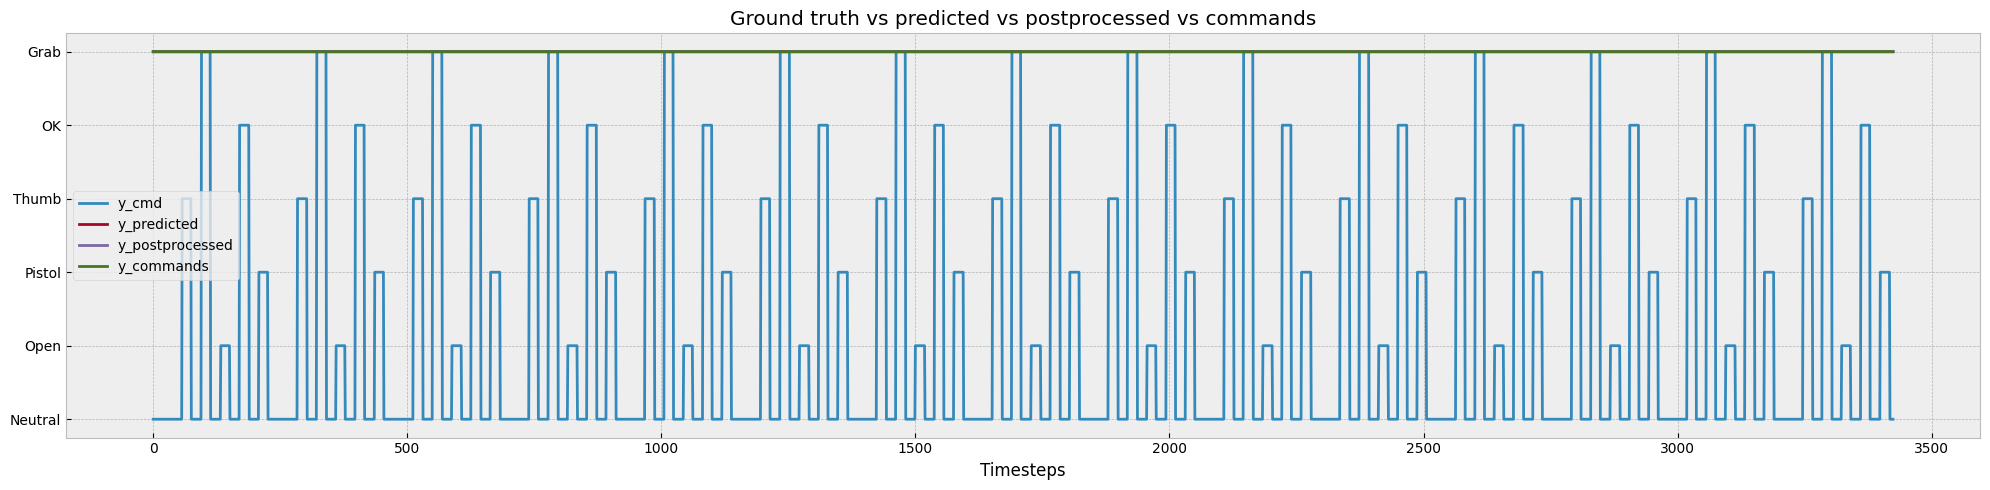

In [74]:
plt.figure(figsize=(20, 5))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.xlabel('Timesteps')

plt.tight_layout()

In [ ]:
print(m.classification_report(y_test, 
                              y_dct['y_commands'], 
                              target_names=GESTURES)) 

### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
# ser_port = '/dev/ttyACM0'
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 